In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score

import xgboost as xgb
from hyperopt import hp, tpe, fmin


pd.set_option('display.max_columns', None)

In [2]:
traindf=pd.read_csv("train.csv")
testdf=pd.read_csv("test.csv")

In [3]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
print(traindf.duplicated().sum())
print(testdf.duplicated().sum())

0
0


In [5]:
list_of_numerics=traindf.select_dtypes(include=['float','int']).columns
types= traindf.dtypes
missing= round((traindf.isnull().sum()/traindf.shape[0]),3)*100
overview= traindf.apply(lambda x: [round(x.min()), 
                                 round(x.max()), 
                                 round(x.mean()), 
                                 round(x.quantile(0.5))] if x.name in list_of_numerics else x.unique())

outliers= traindf.apply(lambda x: sum(
                                 (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25))))|
                                 (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25))))
                                 if x.name in list_of_numerics else ''))


explo = pd.DataFrame({'Types': types,
                      'Missing%': missing,
                      'Overview': overview,
                      'Outliers': outliers}).sort_values(by=['Missing%','Types'],ascending=False)
explo.transpose()

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,BsmtExposure,BsmtFinType2,BsmtQual,BsmtCond,BsmtFinType1,MasVnrType,MasVnrArea,Electrical,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Types,object,object,object,object,object,float64,object,object,object,object,float64,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
Missing%,99.5,96.3,93.8,80.8,47.3,17.7,5.5,5.5,5.5,5.5,5.5,2.6,2.6,2.5,2.5,2.5,0.5,0.5,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Overview,"[nan, Ex, Fa, Gd]","[nan, Shed, Gar2, Othr, TenC]","[nan, Grvl, Pave]","[nan, MnPrv, GdWo, GdPrv, MnWw]","[nan, TA, Gd, Fa, Ex, Po]","[21, 313, 70, 69]","[Attchd, Detchd, BuiltIn, CarPort, nan, Basmen...","[RFn, Unf, Fin, nan]","[TA, Fa, Gd, nan, Ex, Po]","[TA, Fa, nan, Gd, Po, Ex]","[1900, 2010, 1979, 1980]","[No, Gd, Mn, Av, nan]","[Unf, BLQ, nan, ALQ, Rec, LwQ, GLQ]","[Gd, TA, Ex, nan, Fa]","[TA, Gd, nan, Fa, Po]","[GLQ, ALQ, Unf, Rec, BLQ, nan, LwQ]","[BrkFace, None, Stone, BrkCmn, nan]","[0, 1600, 104, 0]","[SBrkr, FuseF, FuseA, FuseP, Mix, nan]","[RL, RM, C (all), FV, RH]","[Pave, Grvl]","[Reg, IR1, IR2, IR3]","[Lvl, Bnk, Low, HLS]","[AllPub, NoSeWa]","[Inside, FR2, Corner, CulDSac, FR3]","[Gtl, Mod, Sev]","[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...","[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...","[Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ...","[1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]","[2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl,...","[Gable, Hip, Gambrel, Mansard, Flat, Shed]","[CompShg, WdShngl, Metal, WdShake, Membran, Ta...","[VinylSd, MetalSd, Wd Sdng, HdBoard, BrkFace, ...","[VinylSd, MetalSd, Wd Shng, HdBoard, Plywood, ...","[Gd, TA, Ex, Fa]","[TA, Gd, Fa, Po, Ex]","[PConc, CBlock, BrkTil, Wood, Slab, Stone]","[GasA, GasW, Grav, Wall, OthW, Floor]","[Ex, Gd, TA, Fa, Po]","[Y, N]","[Gd, TA, Ex, Fa]","[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]","[Y, N, P]","[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ...","[Normal, Abnorml, Partial, AdjLand, Alloca, Fa...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,...","[8450, 9600, 11250, 9550, 14260, 14115, 10084,...","[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]","[5, 8, 6, 7, 4, 2, 3, 9, 1]","[2003, 1976, 2001, 1915, 2000, 1993, 2004, 197...","[2003, 1976, 2002, 1970, 2000, 1995, 2005, 197...","[706, 978, 486, 216, 655, 732, 1369, 859, 0, 8...","[0, 32, 668, 486, 93, 491, 506, 712, 362, 41, ...","[150, 284, 434, 540, 490, 64, 317, 216, 952, 1...","[856, 1262, 920, 756, 1145, 796, 1686, 1107, 9...","[856, 1262, 920, 961, 1145, 796, 1694, 1107, 1...","[854, 0, 866, 756, 1053, 566, 983, 752, 1142, ...","[0, 360, 513, 234, 528, 572, 144, 392, 371, 39...","[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209...","[1, 0, 2, 3]","[0, 1, 2]","[2, 1, 3, 0]","[1, 0, 2]","[3, 4, 1, 2, 0, 5, 6, 8]","[1, 2, 3, 0]","[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 

In [6]:
for col in ('Alley','Utilities','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
           'PoolQC','Fence','MiscFeature'):
    traindf[col]=traindf[col].fillna('None')
    testdf[col]=testdf[col].fillna('None')

In [7]:
for col in ('Electrical','MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional'):
    traindf[col]=traindf[col].fillna(traindf[col].mode()[0])
    testdf[col]=testdf[col].fillna(traindf[col].mode()[0])

In [8]:
for col in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath',
            'GarageYrBlt','GarageCars','GarageArea'):
    traindf[col]=traindf[col].fillna(0)
    testdf[col]=testdf[col].fillna(0)

In [9]:
traindf['LotFrontage']=traindf['LotFrontage'].fillna(traindf['LotFrontage'].mean())
testdf['LotFrontage']=testdf['LotFrontage'].fillna(traindf['LotFrontage'].mean())

In [10]:
print(traindf.isnull().sum().sum())

0


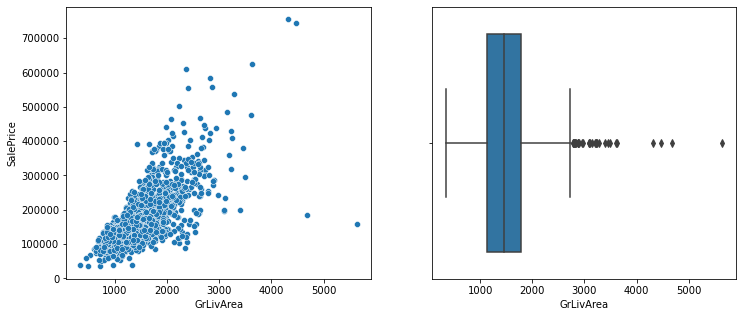

In [11]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

ax1= sns.scatterplot(x='GrLivArea', y='SalePrice', data= traindf,ax=axes[0])
ax2= sns.boxplot(x='GrLivArea', data= traindf,ax=axes[1])

In [12]:
traindf= traindf[traindf['GrLivArea']<4000]

C:\Users\lotar\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


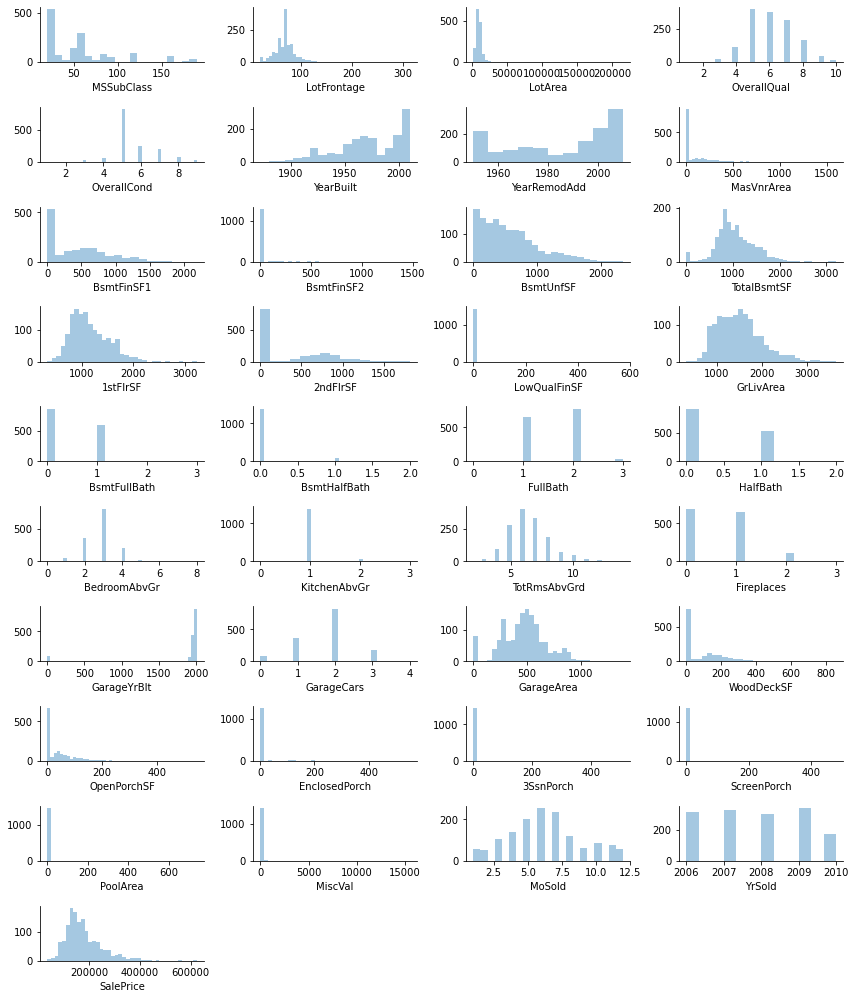

In [13]:
plt.figure(figsize=[12,14])
features=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice']
n=1
for f in features:
    plt.subplot(10,4,n)
    sns.distplot(traindf[f], kde=False)
    sns.despine()
    n=n+1
plt.tight_layout()
plt.show()

In [14]:
len_traindf=traindf.shape[0]
houses= pd.concat([traindf, testdf], sort=False)

for col in ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual",
            "FireplaceQu","GarageQual","GarageCond","PoolQC"]:
    houses[col]= houses[col].map({"Gd": 4 , "TA": 3, "Ex": 5, "Fa":2, "Po":1})


houses= pd.get_dummies(houses)

traindf= houses[:len_traindf]
testdf= houses[len_traindf:]

In [15]:
xtrain= traindf.drop('SalePrice', axis=1)
ytrain= traindf['SalePrice']
xtest= testdf.drop('SalePrice', axis=1)

In [16]:
space = {'n_estimators':hp.quniform('n_estimators', 1000, 4000, 100),
         'gamma':hp.uniform('gamma', 0.01, 0.05),
         'learning_rate':hp.uniform('learning_rate', 0.00001, 0.025),
         'max_depth':hp.quniform('max_depth', 3,7,1),
         'subsample':hp.uniform('subsample', 0.60, 0.95),
         'colsample_bytree':hp.uniform('colsample_bytree', 0.60, 0.98),
         'colsample_bylevel':hp.uniform('colsample_bylevel', 0.60, 0.98),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20)
        }

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
             'gamma': params['gamma'],
             'learning_rate': params['learning_rate'],
             'max_depth': int(params['max_depth']),
             'subsample': params['subsample'],
             'colsample_bytree': params['colsample_bytree'],
             'colsample_bylevel': params['colsample_bylevel'],
             'reg_lambda': params['reg_lambda']}
    
    xb_a= xgb.XGBRegressor(**params)
    score = cross_val_score(xb_a, xtrain, ytrain, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    return -score

In [17]:
best = fmin(fn= objective, space= space, max_evals=20, rstate=np.random.RandomState(1), algo=tpe.suggest)

100%|██████████| 20/20 [06:38<00:00, 19.91s/it, best loss: 474730767.4029846]


In [18]:
print(best)

{'colsample_bylevel': 0.6971640307744038, 'colsample_bytree': 0.6222251306452113, 'gamma': 0.045557016198868025, 'learning_rate': 0.012334455088591312, 'max_depth': 4.0, 'n_estimators': 2100.0, 'reg_lambda': 2.1713829044702413, 'subsample': 0.8459257473555255}


In [19]:
xb_b = xgb.XGBRegressor(random_state=0,
                        n_estimators=int(best['n_estimators']), 
                        colsample_bytree= best['colsample_bytree'],
                        gamma= best['gamma'],
                        learning_rate= best['learning_rate'],
                        max_depth= int(best['max_depth']),
                        subsample= best['subsample'],
                        colsample_bylevel= best['colsample_bylevel'],
                        reg_lambda= best['reg_lambda']
                       )

xb_b.fit(xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.6971640307744038, colsample_bynode=1,
             colsample_bytree=0.6222251306452113, gamma=0.045557016198868025,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.012334455088591312, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=2.1713829044702413, scale_pos_weight=1,
             subsample=0.8459257473555255, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [20]:
preds= xb_b.predict(xtest)

In [21]:
output = pd.DataFrame({'Id': testdf.Id,'SalePrice': preds})
output.to_csv('submission.csv', index=False)